<a href="https://colab.research.google.com/github/Waranika/DCU-EE514-DA-ML/blob/main/Assignement/Assignement_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

In [2]:
path = "/content/drive/MyDrive/The ExtraSensory Dataset/ExtraSensory.per_uuid_features_labels"

In [3]:
files = [f for f in os.listdir(path) if f.endswith('.gz')]
print(files)

['A5A30F76-581E-4757-97A2-957553A2C6AA.features_labels.csv.gz', 'BEF6C611-50DA-4971-A040-87FB979F3FC1.features_labels.csv.gz', '098A72A5-E3E5-4F54-A152-BBDA0DF7B694.features_labels.csv.gz', 'D7D20E2E-FC78-405D-B346-DBD3FD8FC92B.features_labels.csv.gz', '2C32C23E-E30C-498A-8DD2-0EFB9150A02E.features_labels.csv.gz', '136562B6-95B2-483D-88DC-065F28409FD2.features_labels.csv.gz', '11B5EC4D-4133-4289-B475-4E737182A406.features_labels.csv.gz', '4FC32141-E888-4BFF-8804-12559A491D8C.features_labels.csv.gz', '86A4F379-B305-473D-9D83-FC7D800180EF.features_labels.csv.gz', 'CA820D43-E5E2-42EF-9798-BE56F776370B.features_labels.csv.gz', 'A5CDF89D-02A2-4EC1-89F8-F534FDABDD96.features_labels.csv.gz', 'B7F9D634-263E-4A97-87F9-6FFB4DDCB36C.features_labels.csv.gz', '1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842.features_labels.csv.gz', '74B86067-5D4B-43CF-82CF-341B76BEA0F4.features_labels.csv.gz', '33A85C34-CFE4-4732-9E73-0A7AC861B27A.features_labels.csv.gz', '9759096F-1119-4E19-A0AD-6F16989C7E1C.features_labels.

In [4]:
df = pd.DataFrame()
# Loop through each .gz file, unzip, and append to the DataFrame
for gz_file in files:
    with gzip.open(os.path.join(path, gz_file), 'rt') as f:
        data = pd.read_csv(f, delimiter=',')
        df = pd.concat([df, data], ignore_index=True)

In [5]:
print(df)

         timestamp  raw_acc:magnitude_stats:mean  raw_acc:magnitude_stats:std  \
0       1437680357                      1.000726                     0.002890   
1       1437680405                      1.001435                     0.002014   
2       1437680465                      1.001515                     0.003096   
3       1437680526                      1.000972                     0.001954   
4       1437680616                      1.001143                     0.025751   
...            ...                           ...                          ...   
377341  1464895317                      1.000707                     0.050293   
377342  1464895378                      0.996989                     0.007465   
377343  1464895455                      0.996782                     0.011491   
377344  1464895515                      0.995879                     0.002902   
377345  1464895575                      0.994668                     0.002042   

        raw_acc:magnitude_s

*DATA REPRESENTATION*

In [6]:
df.describe()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
count,3.773460e+05,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,...,94415.000000,71196.000000,306594.000000,259164.000000,141703.000000,92462.000000,162423.000000,112064.000000,165414.000000,377346.000000
mean,1.445839e+09,1.002223,0.038832,0.037772,0.072804,0.983165,0.998471,1.016691,2.045331,6.680278,...,0.008198,0.002809,0.123231,0.163337,0.102842,0.110326,0.708256,0.055540,0.149546,1.565261
std,5.907009e+06,0.079623,0.096109,0.113198,0.170481,0.082960,0.076687,0.104874,0.616899,0.021246,...,0.090171,0.052927,0.328703,0.369673,0.303753,0.313298,0.454567,0.229032,0.356627,1.463029
min,1.433537e+09,0.018148,0.000030,-0.493806,0.000039,0.015845,0.017998,0.020365,0.009605,5.460637,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,1.441438e+09,0.992556,0.001709,-0.000785,0.002328,0.982671,0.991248,0.994859,1.671571,6.684369,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,1.444974e+09,1.001258,0.003265,0.000772,0.005051,0.995300,1.000116,1.003813,2.296398,6.684606,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
75%,1.448696e+09,1.012745,0.021366,0.009864,0.045333,1.003679,1.009232,1.019163,2.523618,6.684610,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
max,1.464899e+09,3.185837,1.936343,2.472750,3.360718,1.942718,2.636697,3.958338,2.971272,6.684612,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [7]:
# Extracting columns starting with 'proc' or 'raw'
raw_data_readings = df.filter(regex='^(proc|raw)')

# Describing the selected columns
raw_data_readings.describe()


,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,...,raw_magnet:3d:std_y,raw_magnet:3d:std_z,raw_magnet:3d:ro_xy,raw_magnet:3d:ro_xz,raw_magnet:3d:ro_yz,raw_magnet:avr_cosine_similarity_lag_range0,raw_magnet:avr_cosine_similarity_lag_range1,raw_magnet:avr_cosine_similarity_lag_range2,raw_magnet:avr_cosine_similarity_lag_range3,raw_magnet:avr_cosine_similarity_lag_range4
count,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,...,346025.000000,346025.000000,345149.000000,345575.000000,345449.000000,346025.000000,346025.000000,346025.000000,346025.000000,346025.000000
mean,1.002223,0.038832,0.037772,0.072804,0.983165,0.998471,1.016691,2.045331,6.680278,5.039597,...,2.662531,2.904427,0.016559,0.011607,-0.003313,0.999449,0.999121,0.998286,0.996813,0.986172
std,0.079623,0.096109,0.113198,0.170481,0.082960,0.076687,0.104874,0.616899,0.021246,0.025809,...,11.445300,11.780716,0.390024,0.398956,0.387409,0.015529,0.016046,0.018115,0.033389,0.105407
min,0.018148,0.000030,-0.493806,0.000039,0.015845,0.017998,0.020365,0.009605,5.460637,4.338109,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-0.320454,-0.905040,-0.948784
25%,0.992556,0.001709,-0.000785,0.002328,0.982671,0.991248,0.994859,1.671571,6.684369,5.042891,...,0.737282,0.731671,-0.074774,-0.132440,-0.100137,0.999936,0.999888,0.999844,0.999809,0.999750
50%,1.001258,0.003265,0.000772,0.005051,0.995300,1.000116,1.003813,2.296398,6.684606,5.043350,...,0.785152,0.802989,0.005513,-0.020600,-0.003247,0.999990,0.999986,0.999984,0.999982,0.999980
75%,1.012745,0.021366,0.009864,0.045333,1.003679,1.009232,1.019163,2.523618,6.684610,5.043574,...,1.627928,1.726690,0.103366,0.099251,0.080320,0.999996,0.999995,0.999995,0.999995,0.999995
max,3.185837,1.936343,2.472750,3.360718,1.942718,2.636697,3.958338,2.971272,6.684612,6.489025,...,2176.581348,1744.604115,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Extracting columns starting with watch
raw_watch_readings = df.filter(like='watch')

# Describing the selected columns
raw_watch_readings.describe()

,watch_acceleration:magnitude_stats:mean,watch_acceleration:magnitude_stats:std,watch_acceleration:magnitude_stats:moment3,watch_acceleration:magnitude_stats:moment4,watch_acceleration:magnitude_stats:percentile25,watch_acceleration:magnitude_stats:percentile50,watch_acceleration:magnitude_stats:percentile75,watch_acceleration:magnitude_stats:value_entropy,watch_acceleration:magnitude_stats:time_entropy,watch_acceleration:magnitude_spectrum:log_energy_band0,...,watch_acceleration:relative_directions:avr_cosine_similarity_lag_range4,watch_heading:mean_cos,watch_heading:std_cos,watch_heading:mom3_cos,watch_heading:mom4_cos,watch_heading:mean_sin,watch_heading:std_sin,watch_heading:mom3_sin,watch_heading:mom4_sin,watch_heading:entropy_8bins
count,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,...,244802.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000
mean,1028.890233,65.731225,54.667315,122.592605,998.783850,1023.673423,1052.407856,1.997444,5.910505,5.021269,...,0.797822,-0.025359,0.302725,0.003126,0.392300,-0.015159,0.287672,0.006082,0.373939,0.765980
std,49.106854,91.525328,125.109478,174.731291,39.357481,39.913269,85.110513,0.490164,0.414305,0.346167,...,0.324213,0.582469,0.266041,0.359798,0.325597,0.590086,0.257848,0.343698,0.316107,0.648247
min,880.184417,2.935715,-535.244867,3.987740,428.634690,819.912190,941.080230,0.014427,2.962748,0.000000,...,-0.974939,-0.999895,0.000076,-0.914928,0.000076,-0.999878,0.000000,-0.914815,0.000000,-0.000000
25%,1006.345562,13.236651,-6.337331,19.744464,985.673373,1004.597432,1015.653484,1.734896,5.777048,5.042606,...,0.706914,-0.513068,0.027293,-0.222469,0.037471,-0.520331,0.029196,-0.191700,0.039120,-0.000000
50%,1022.198931,21.722183,8.367984,36.034501,1000.831654,1018.924924,1033.804597,2.134219,6.100122,5.045679,...,0.981081,-0.030001,0.265439,0.001584,0.385268,-0.031349,0.237999,0.001560,0.346446,0.713510
75%,1039.027288,85.678335,73.436227,164.121720,1016.527281,1034.353905,1058.179533,2.343302,6.213958,5.049228,...,0.999717,0.459541,0.538895,0.230924,0.708518,0.489492,0.514285,0.221637,0.683331,1.331647
max,2500.947775,1505.690106,1741.172696,2154.495365,2098.761540,2357.225259,3357.256601,2.963879,6.214595,6.009607,...,0.999983,0.999927,0.998065,0.914136,1.072989,0.999921,0.994814,0.915049,1.073294,2.071655


In [9]:
missing_values_raw_data = raw_data_readings.isnull().sum()
missing_values_raw_watch = raw_watch_readings.isnull().sum()
print(missing_values_raw_data)
print(missing_values_raw_watch)

raw_acc:magnitude_stats:mean                     290
raw_acc:magnitude_stats:std                      290
raw_acc:magnitude_stats:moment3                  290
raw_acc:magnitude_stats:moment4                  290
raw_acc:magnitude_stats:percentile25             290
                                               ...  
raw_magnet:avr_cosine_similarity_lag_range0    31321
raw_magnet:avr_cosine_similarity_lag_range1    31321
raw_magnet:avr_cosine_similarity_lag_range2    31321
raw_magnet:avr_cosine_similarity_lag_range3    31321
raw_magnet:avr_cosine_similarity_lag_range4    31321
Length: 83, dtype: int64
watch_acceleration:magnitude_stats:mean                                    132544
watch_acceleration:magnitude_stats:std                                     132544
watch_acceleration:magnitude_stats:moment3                                 132544
watch_acceleration:magnitude_stats:moment4                                 132544
watch_acceleration:magnitude_stats:percentile25                 

Overall Average Missing Values in raw_data_readings: 0.045947955214667
Overall Average Missing Values in raw_watch_readings: 0.3934851689045453


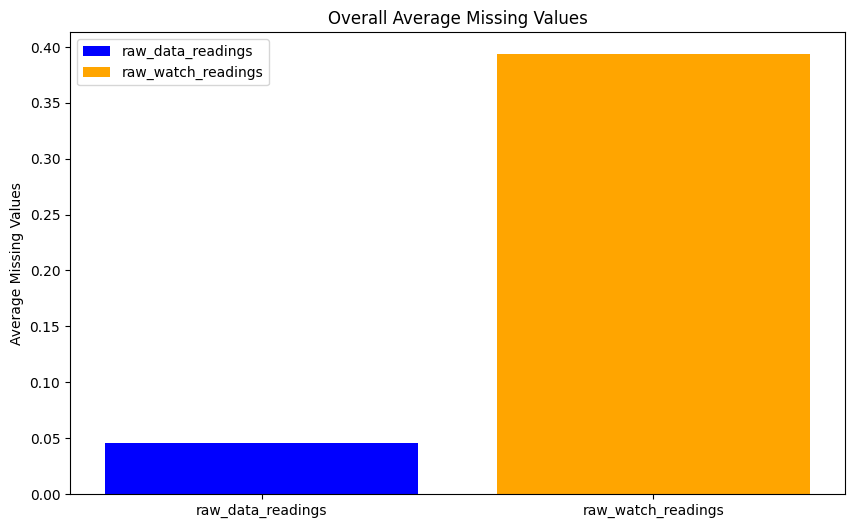

In [10]:
# Calculate the overall average of missing values for each DataFrame
overall_average_missing_raw_data = raw_data_readings.isnull().mean().mean()
overall_average_missing_raw_watch = raw_watch_readings.isnull().mean().mean()

# Print the overall average missing values for each DataFrame
print("Overall Average Missing Values in raw_data_readings:", overall_average_missing_raw_data)
print("Overall Average Missing Values in raw_watch_readings:", overall_average_missing_raw_watch)

# Plotting the overall average missing values for each DataFrame
plt.figure(figsize=(10, 6))


plt.bar("raw_data_readings", overall_average_missing_raw_data, color="blue", label="raw_data_readings")
plt.bar("raw_watch_readings", overall_average_missing_raw_watch, color="orange", label="raw_watch_readings")

plt.title('Overall Average Missing Values')
plt.ylabel('Average Missing Values')
plt.legend()
plt.show()

In [11]:
watch_columns = df.filter(like="watch")
print(watch_columns.sum())
df = df.drop(columns=watch_columns)
df.shape

watch_acceleration:magnitude_stats:mean                                    2.518744e+08
watch_acceleration:magnitude_stats:std                                     1.609114e+07
watch_acceleration:magnitude_stats:moment3                                 1.338267e+07
watch_acceleration:magnitude_stats:moment4                                 3.001091e+07
watch_acceleration:magnitude_stats:percentile25                            2.445043e+08
watch_acceleration:magnitude_stats:percentile50                            2.505973e+08
watch_acceleration:magnitude_stats:percentile75                            2.576315e+08
watch_acceleration:magnitude_stats:value_entropy                           4.889784e+05
watch_acceleration:magnitude_stats:time_entropy                            1.446903e+06
watch_acceleration:magnitude_spectrum:log_energy_band0                     1.229217e+06
watch_acceleration:magnitude_spectrum:log_energy_band1                     6.653512e+04
watch_acceleration:magnitude_spe

(377346, 223)

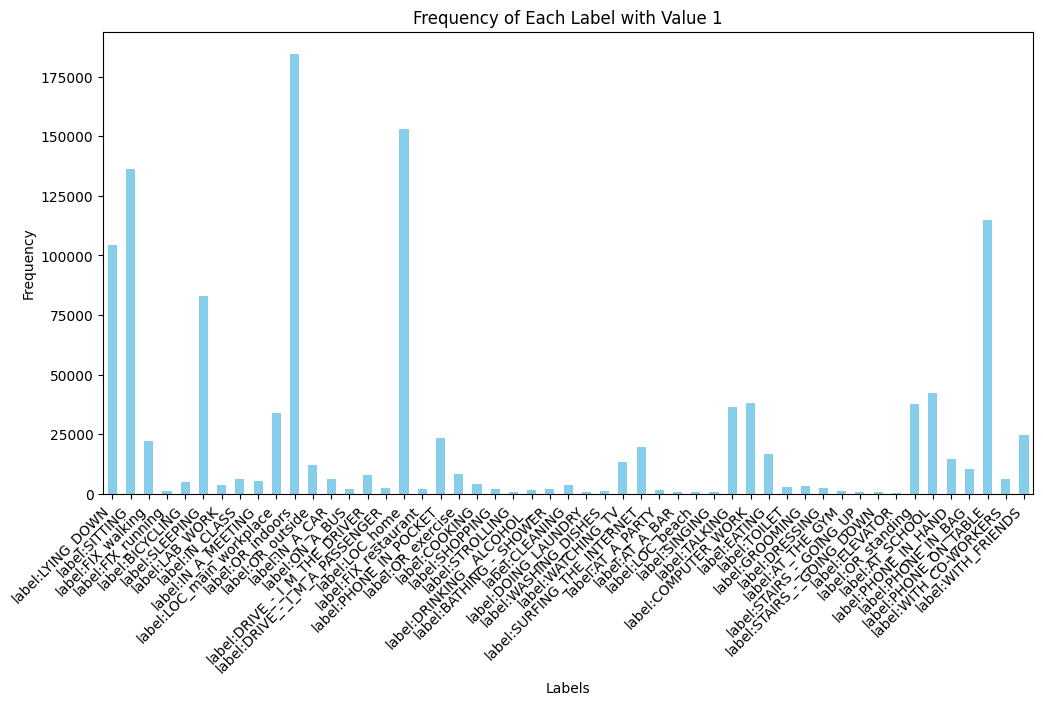

In [12]:
# Extracting only the 'label' columns
label_columns = df.filter(like='label:')


# Counting the occurrences of value 1 in each 'label' column
label_counts = label_columns.sum()


plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Label with Value 1')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

*PREPROCESSING*

Delete incomplete columns


In [13]:
count = 0
j = 0
for i in df.columns:
    if j > 225:
        break
    # Check if the column name starts with "label:"
    if not i.startswith("label:"):
        # Count the occurrences of 'na' in each column
        count = (df[i] == 'nan').sum()
        j = j + 1
        # Check if the total count of 'na' values and NaN values exceeds a threshold
        if df[i].isnull().sum() + count > 377346 * 0.6:
            print(i)
            print(df[i].isnull().sum() + count)
            del df[i]
    else:
        j = j + 1

location:min_speed
272817
location:max_speed
272817
lf_measurements:light
230314
lf_measurements:pressure
270151
lf_measurements:proximity_cm
228726
lf_measurements:relative_humidity
351407
lf_measurements:temperature_ambient
350896


In [14]:
df.shape

(377346, 216)

Delete irrelevant columns for the analysis

In [15]:
del df['timestamp']
df.shape

(377346, 215)

Delete known biased columns that might wrong the prediction

Correlation Matrix:
                              location:num_valid_updates  \
location:num_valid_updates                      1.000000   
location:log_latitude_range                     0.261537   
location:log_longitude_range                    0.266808   
location:min_altitude                          -0.021025   
location:max_altitude                          -0.006527   
...                                                  ...   
label:PHONE_IN_BAG                              0.118952   
label:PHONE_ON_TABLE                           -0.042768   
label:WITH_CO-WORKERS                          -0.175446   
label:WITH_FRIENDS                              0.119985   
label_source                                   -0.004276   

                              location:log_latitude_range  \
location:num_valid_updates                       0.261537   
location:log_latitude_range                      1.000000   
location:log_longitude_range                     0.760948   
location:min_al

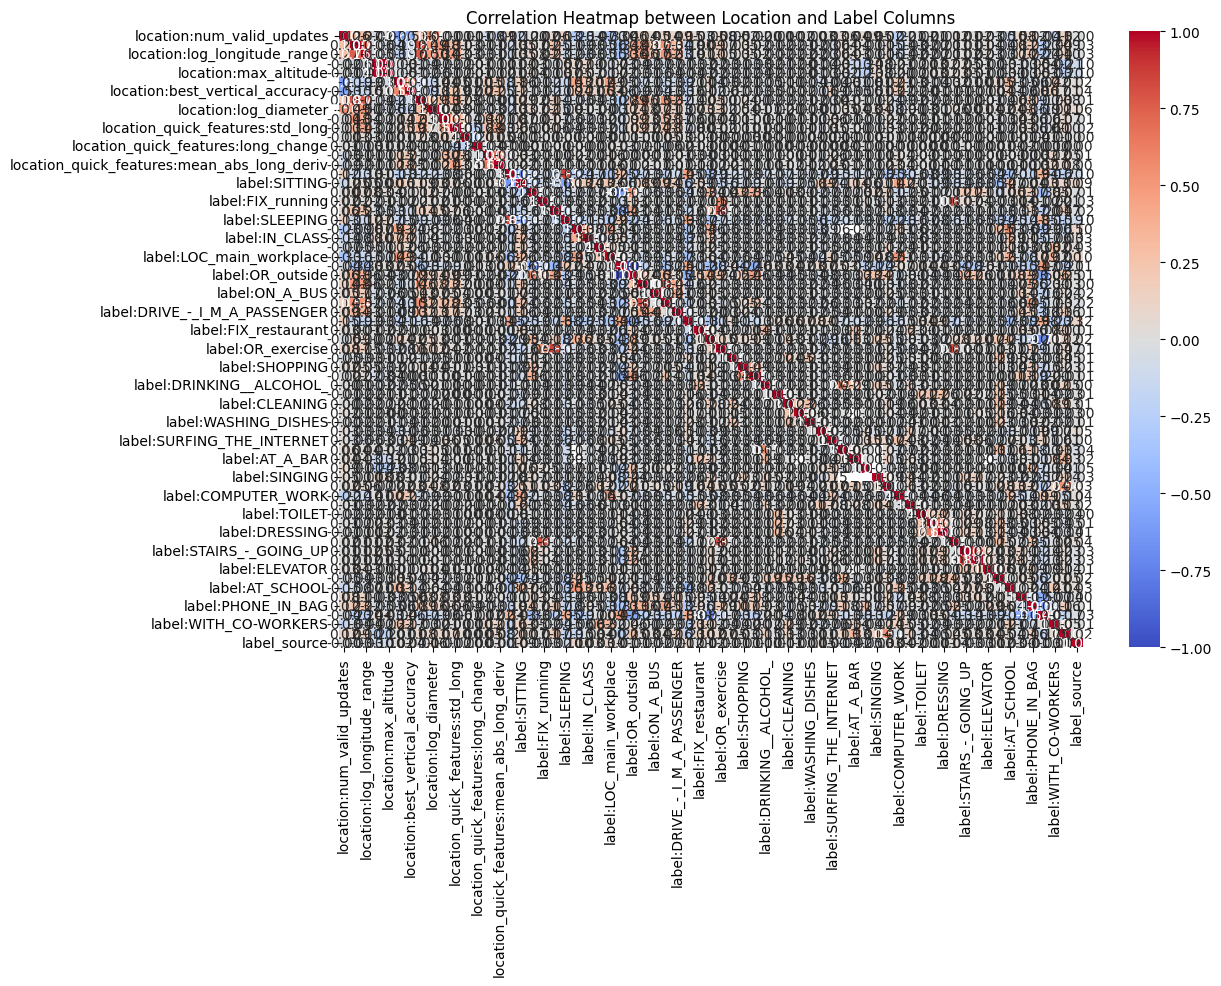

In [16]:
# Select columns starting with 'location' and 'label'
location_columns = df.filter(regex='^location')
label_columns = df.filter(regex='^label')

# Concatenate the selected columns
selected_columns = pd.concat([location_columns, label_columns], axis=1)

# Calculate the correlation matrix
correlation_matrix = selected_columns.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Location and Label Columns')
plt.show()

In [17]:
df = df.drop(columns=location_columns)
df.shape

(377346, 200)

Check if there is correlation between column and label  to predict

In [18]:
df.columns

Index(['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std',
       'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4',
       'raw_acc:magnitude_stats:percentile25',
       'raw_acc:magnitude_stats:percentile50',
       'raw_acc:magnitude_stats:percentile75',
       'raw_acc:magnitude_stats:value_entropy',
       'raw_acc:magnitude_stats:time_entropy',
       'raw_acc:magnitude_spectrum:log_energy_band0',
       ...
       'label:STAIRS_-_GOING_DOWN', 'label:ELEVATOR', 'label:OR_standing',
       'label:AT_SCHOOL', 'label:PHONE_IN_HAND', 'label:PHONE_IN_BAG',
       'label:PHONE_ON_TABLE', 'label:WITH_CO-WORKERS', 'label:WITH_FRIENDS',
       'label_source'],
      dtype='object', length=200)

In [19]:
# Select columns that start with "raw", "proc", or "audio"
selected_columns = [col for col in df.columns if col.startswith(("raw", "proc", "audio"))]

# Extract the selected columns and create a new DataFrame
df_selected = df[selected_columns]

# Standardize the selected columns
scaler = StandardScaler()
df_selected_standardized = pd.DataFrame(scaler.fit_transform(df_selected), columns=selected_columns)

# Replace the original columns with the standardized ones in the original DataFrame
df[selected_columns] = df_selected_standardized

#For the sake of time the 500 first values of df are taken
df = df.head(500)

In [20]:
missing_columns = df.columns[df.isnull().any()]
missing_values = df[missing_columns].isnull().sum()

print("Columns with Missing Values:")
print(missing_values)

Columns with Missing Values:
lf_measurements:proximity            500
lf_measurements:screen_brightness    500
label:BICYCLING                      500
label:IN_CLASS                       500
label:OR_indoors                     355
label:OR_outside                     500
label:ON_A_BUS                       500
label:DRIVE_-_I_M_THE_DRIVER         500
label:DRIVE_-_I_M_A_PASSENGER        500
label:FIX_restaurant                 500
label:PHONE_IN_POCKET                380
label:STROLLING                      500
label:DRINKING__ALCOHOL_             500
label:DOING_LAUNDRY                  500
label:WASHING_DISHES                 500
label:WATCHING_TV                    500
label:SURFING_THE_INTERNET           500
label:AT_A_PARTY                     500
label:AT_A_BAR                       500
label:LOC_beach                      500
label:SINGING                        500
label:GROOMING                       500
label:DRESSING                       500
label:PHONE_IN_HAND         

BUILD MODEL

In [21]:
y = df.filter(regex='^label:')
x = df.drop(columns= y)

print(y.shape)


#Replace missing by 0
y.fillna(0, inplace=True)
x.fillna(0, inplace=True)


X_encoded = pd.get_dummies(x)
y_encoded = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(X_encoded.values, y_encoded.values, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

(500, 51)


<ipython-input-21-746fcf1fadda>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


In [22]:
print(X_train)

[[ 1.74267431e-01  2.44036104e-01  1.86487938e-01 ...  0.00000000e+00
   0.00000000e+00  2.00000000e+00]
 [-2.81370424e-02 -3.81013248e-01 -3.49501594e-01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 3.49964580e-03 -3.84779796e-01 -3.41895460e-01 ...  1.00000000e+00
   1.00000000e+00  2.00000000e+00]
 ...
 [ 2.56745291e+00  4.06143296e+00  2.69473661e+00 ...  0.00000000e+00
   0.00000000e+00  2.00000000e+00]
 [ 9.55319234e-03 -3.45876137e-01 -3.68600854e-01 ...  0.00000000e+00
   0.00000000e+00  2.00000000e+00]
 [ 2.09056484e-01  9.89053145e-01  1.29072903e+00 ...  1.00000000e+00
   1.00000000e+00  4.00000000e+00]]


In [25]:
# Define the classifier (Random Forest in this case)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a MultiOutputClassifier
multi_output_classifier = MultiOutputClassifier(classifier, n_jobs=-1)

# Fit the model
multi_output_classifier.fit(X_train, y_train)
validation_score = multi_output_classifier.score(X_val, y_val)
print(f"Validation Score: {validation_score}")


Validation Score: 0.625


CHECK RESULTS


In [26]:
# Make predictions
y_pred = multi_output_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.88      0.94      0.91        72
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.75      0.86         4
           6       0.73      0.84      0.78        19
           7       0.00      0.00      0.00         0
           8       1.00      0.86      0.92         7
           9       1.00      0.96      0.98        23
          10       1.00      0.72      0.84        18
          11       0.00      0.00      0.00         0
          12       0.89      0.89      0.89        19
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       1.00      1.00      1.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Convert predicted probabilities to binary labels
#y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[[ 93   0]
  [  3   4]]

 [[ 19   9]
  [  4  68]]

 [[ 96   0]
  [  3   1]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[ 96   0]
  [  1   3]]

 [[ 75   6]
  [  3  16]]

 [[100   0]
  [  0   0]]

 [[ 93   0]
  [  1   6]]

 [[ 77   0]
  [  1  22]]

 [[ 82   0]
  [  5  13]]

 [[100   0]
  [  0   0]]

 [[ 79   2]
  [  2  17]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[ 89   0]
  [  0  11]]

 [[100   0]
  [  0   0]]

 [[ 77   1]
  [  9  13]]

 [[ 97   0]
  [  1   2]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[100   0]
  [  0   0]]

 [[ 93   0]
  [  1   6]]

 [[ 54   2]
  [  4  40]]

 [[ 98   0]
  [  2   0]]

 [[ 96   0]
  [  4  